Optimal alpha for minimum variance (sparsified): [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.08931271 0.08438264 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.09792752
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.

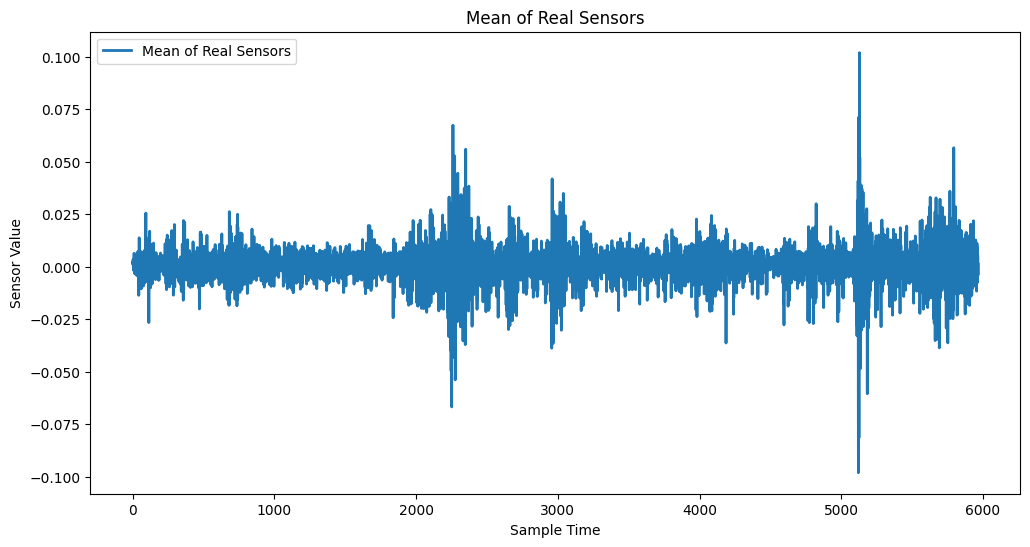

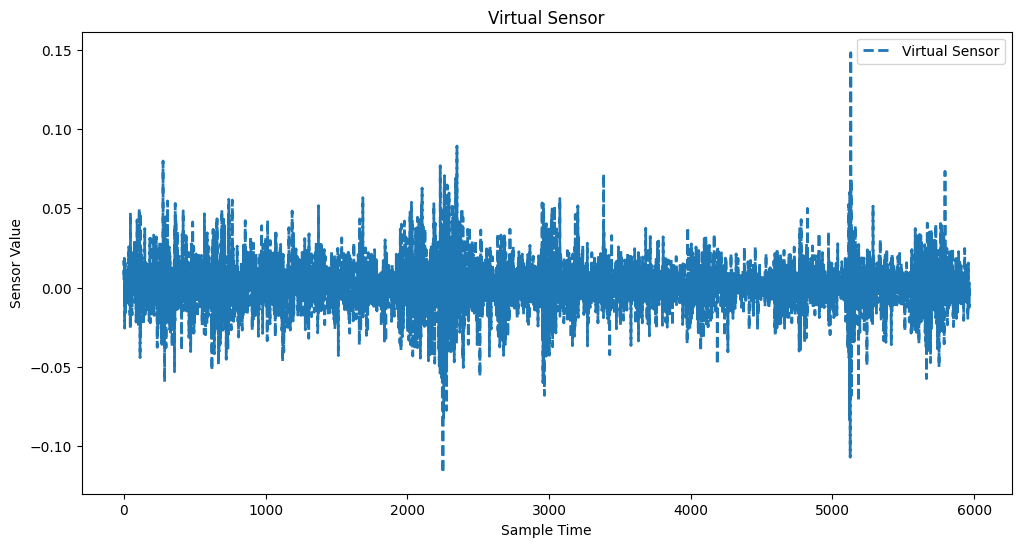

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Step 1: Load and preprocess the data
data = pd.read_csv('../data.csv')

# Pivot the data to create a matrix with SampleTime as rows and SensorID as columns
data_pivot = data.pivot(index='SampleTime', columns='SensorID', values='Value')

# Fill missing values with zeros or the mean of the column
data_pivot = data_pivot.fillna(0)

# Calculate statistics
mu_X = data_pivot.mean(axis=0).values  # Mean of each sensor
Gamma_X = np.cov(data_pivot.T)  # Covariance matrix of the sensors

# Number of sensors
n = data_pivot.shape[1]

# Define B (maximum number of sensors to use)
B = 10  # Example value, adjust according to the problem

# Step 2.1: Define the optimization problem for variance minimization

# Define the objective function for variance
def variance_objective(alpha):
    return alpha.T @ Gamma_X @ alpha

# Define the constraints
def sum_alpha(alpha):
    return np.sum(alpha) - 1

constraints = [
    {'type': 'eq', 'fun': sum_alpha},  # Sum of alphas should be 1
    {'type': 'ineq', 'fun': lambda alpha: B - np.sum(np.ceil(alpha))}  # Constraint for number of sensors
]

# Bounds for alpha
bounds = [(0, 1) for _ in range(n)]

# Initial guess for alpha
alpha_init = np.ones(n) / n

# Minimize variance without penalty
result_var = minimize(variance_objective, alpha_init, bounds=bounds, constraints=constraints)
alpha_opt_var = result_var.x

# Enforce sparsity for variance minimization
non_zero_indices_var = np.argsort(-alpha_opt_var)[:B]
alpha_sparsified_var = np.zeros_like(alpha_opt_var)
alpha_sparsified_var[non_zero_indices_var] = alpha_opt_var[non_zero_indices_var]
alpha_sparsified_var /= np.sum(alpha_sparsified_var)  # Re-normalize to ensure the sum is 1
sigma2_1 = alpha_sparsified_var.T @ Gamma_X @ alpha_sparsified_var

# Print the results of the variance minimization
print("Optimal alpha for minimum variance (sparsified):", alpha_sparsified_var)
print("Minimum variance:", sigma2_1)

# Step 2.2: Define the optimization problem for mean maximization

# Define the objective function for expected value
def mean_objective(alpha):
    return -np.sum(mu_X * alpha)  # We minimize the negative to maximize the positive

# Define the constraints for the mean optimization
def variance_constraint(alpha):
    return sigma2_1 - alpha.T @ Gamma_X @ alpha

constraints_mean = constraints + [
    {'type': 'ineq', 'fun': variance_constraint}  # Variance <= sigma2_1
]

# Maximize mean without penalty
result_mean = minimize(mean_objective, alpha_init, bounds=bounds, constraints=constraints_mean)
alpha_opt_mean = result_mean.x

# Enforce sparsity for mean maximization
non_zero_indices_mean = np.argsort(-alpha_opt_mean)[:B]
alpha_sparsified_mean = np.zeros_like(alpha_opt_mean)
alpha_sparsified_mean[non_zero_indices_mean] = alpha_opt_mean[non_zero_indices_mean]
alpha_sparsified_mean /= np.sum(alpha_sparsified_mean)  # Re-normalize to ensure the sum is 1
mu2 = -np.sum(mu_X * alpha_sparsified_mean)  # Negate back to get the positive mean

# Print the results of the mean maximization
print("Optimal alpha for maximum mean (sparsified):", alpha_sparsified_mean)
print("Maximum mean:", mu2)

# Step 3: Calculate the virtual sensor

# Calculate the virtual sensor
virtual_sensor = data_pivot @ alpha_sparsified_mean

# Save the virtual sensor to a CSV file with the same structure as data.csv
virtual_sensor_df = pd.DataFrame({
    'SampleTime': data_pivot.index,
    'SensorID': 0,
    'Value': virtual_sensor
})
virtual_sensor_df.to_csv('virtual_sensor.csv', index=False)

# Calculate the mean of real sensors
mean_real_sensors = data_pivot.mean(axis=1)

# Plot the mean of real sensors
plt.figure(figsize=(12, 6))
plt.plot(data_pivot.index, mean_real_sensors, label='Mean of Real Sensors', linewidth=2)
plt.xlabel('Sample Time')
plt.ylabel('Sensor Value')
plt.title('Mean of Real Sensors')
plt.legend()
plt.show()

# Plot the virtual sensor
plt.figure(figsize=(12, 6))
plt.plot(data_pivot.index, virtual_sensor, label='Virtual Sensor', linewidth=2, linestyle='--')
plt.xlabel('Sample Time')
plt.ylabel('Sensor Value')
plt.title('Virtual Sensor')
plt.legend()
plt.show()